# Problem Statement: **Hyperparameter Tuning for AtliQ’s Fashion Item Classifier**

### AtliQ Fashion wants to develop a neural network to classify fashion items using the FashionMNIST dataset. Your task is to optimize the neural network's performance by fine-tuning its hyperparameters. We will be using **FashionMNIST** dataset but since the dataset is large, we will work with only a subset to ensure that the solution is computationally feasible.

**References:**

* transforms.Compose (PyTorch): [Link](https://pytorch.org/vision/master/generated/torchvision.transforms.Compose.html)
* Optuna (Hyperparameter Optimization Framework) [Link](https://optuna.readthedocs.io/en/stable/)

Imports and CUDA

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.7 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import optuna
import random

# Check if CUDA (GPU) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu




---



**Dataset Overview**

* Dataset: FashionMNIST
* Classes: 10 (e.g., T-shirts, trousers, shoes)
* Training Images: Subset of 10,000 (randomly sampled from 60,000)
* Test Images: Subset of 2,000 (randomly sampled from 10,000)



---



**Step1**: Load and Sample the Dataset

* Load the FashionMNIST dataset using torchvision.datasets.
* Sample 10,000 images for training and 2,000 images for testing.
* Normalize the pixel values to the range [-1, 1].
* Create PyTorch DataLoaders for the training and test sets.

In [ ]:
# Transform: Normalize and convert to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Centers the pixel values around 0 and scales them to [-1, 1]
])

# Load FashionMNIST dataset

dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)



# Sample the datset

train_subset_size = 10000
test_subset_size = 2000


100%|██████████| 26.4M/26.4M [00:01<00:00, 15.7MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 269kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.06MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.62MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



**Key Insight:**

* Sampling a smaller subset reduces computational cost, making it feasible for learners.
* Normalizing to [-1, 1] helps the model converge faster and avoid numerical instability.




---



**Step2**: Create Dataloaders

* batch size = 32


In [ ]:
train_subset, _ = random_split(dataset, [train_subset_size, len(dataset) - train_subset_size])
test_subset, _ = random_split(test_dataset, [test_subset_size, len(test_dataset) - test_subset_size])

In [ ]:
batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

In [ ]:
print(f"Training data size: {len(train_subset)}")
print(f"Testing data size: {len(test_subset)}")

Training data size: 10000
Testing data size: 2000


**Key Insights**

* `random_split` is a PyTorch utility that randomly divides a dataset into two subsets.
* The first subset will have `size1` samples, and the second subset will have `size2` samples.



---



**Step3**: Define the Neural Network

* Create a fully connected feed-forward neural network (no CNN).

Structure:
* Input layer: 784 neurons (28x28 image flattened).
* 1st hidden layer: 128 neurons with ReLU activation.
* 2nd hidden layer: 64 neurons with ReLU activation.
* Output layer: 10 neurons (one for each class) with Softmax activation.

Use `nn.Sequential`

In [ ]:
class FashionNN(nn.Module):
    def __init__(self):
        super(FashionNN, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(),          # Flatten the input tensor
            nn.Linear(28*28, 128), # Input layer (784)
            nn.ReLU(),             # Activation
            nn.Linear(128, 64),    # Hidden layer 1
            nn.ReLU(),             # Activation
            nn.Linear(64, 10),     # Output layer (10 classes)
            nn.Softmax(dim=1)      # Softmax for probabilities
        )

    def forward(self, x):
        return self.network(x)  # No need for explicit flattening



FashionNN(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
    (5): Softmax(dim=1)
  )
)


**Key Insight**

* Flattening 28x28 images to 784 ensures compatibility with linear layers.




---



**Step 3**: Train the Base Model

Instructions:

Set the following base hyperparameters:
* Loss function: Cross Entropy Loss
* Learning rate: 0.01
* Batch size: 32
* Optimizer: SGD
* Epochs: 100

Train the model and record the training/validation accuracy and loss.


In [ ]:
# Define loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()  # Set model to training mode
    for images, labels in train_loader:
        # Zero gradients
        optimizer.zero_grad()
        # Forward pass
        predictions = model(images)
        loss = loss_function(predictions, labels)
        # Backward pass
        loss.backward()
        optimizer.step()
        # Append the training loss
        train_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader):.4f}")


Epoch 1/100, Loss: 2.2045
Epoch 2/100, Loss: 2.1812
Epoch 3/100, Loss: 2.1578
Epoch 4/100, Loss: 2.1284
Epoch 5/100, Loss: 2.0950
Epoch 6/100, Loss: 2.0648
Epoch 7/100, Loss: 2.0385
Epoch 8/100, Loss: 2.0141
Epoch 9/100, Loss: 1.9938
Epoch 10/100, Loss: 1.9707
Epoch 11/100, Loss: 1.9490
Epoch 12/100, Loss: 1.9320
Epoch 13/100, Loss: 1.9164
Epoch 14/100, Loss: 1.9005
Epoch 15/100, Loss: 1.8877
Epoch 16/100, Loss: 1.8756
Epoch 17/100, Loss: 1.8655
Epoch 18/100, Loss: 1.8559
Epoch 19/100, Loss: 1.8465
Epoch 20/100, Loss: 1.8374
Epoch 21/100, Loss: 1.8280
Epoch 22/100, Loss: 1.8191
Epoch 23/100, Loss: 1.8107
Epoch 24/100, Loss: 1.8026
Epoch 25/100, Loss: 1.7973
Epoch 26/100, Loss: 1.7890
Epoch 27/100, Loss: 1.7838
Epoch 28/100, Loss: 1.7782
Epoch 29/100, Loss: 1.7755
Epoch 30/100, Loss: 1.7686
Epoch 31/100, Loss: 1.7662
Epoch 32/100, Loss: 1.7608
Epoch 33/100, Loss: 1.7582
Epoch 34/100, Loss: 1.7558
Epoch 35/100, Loss: 1.7538
Epoch 36/100, Loss: 1.7512
Epoch 37/100, Loss: 1.7479
Epoch 38/1



---



**Step 4**: Perform Hyperparameter Tuning
Instructions:

**Grid Search:**

Hyperparameters:
* Learning rate: [0.001, 0.01, 0.1]
* Batch size: [32, 64]
* Evaluate all combinations systematically.

In [ ]:
# Define grid search parameters
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64]

# Train and evaluate for all combinations
best_loss = float('inf')
best_params = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        optimizer = optim.SGD(model.parameters(), lr=lr)
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        train_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            predictions = model(images)
            loss = loss_function(predictions, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_loss = train_loss / len(train_loader)
        print(f"LR: {lr}, Batch size: {batch_size}, Loss: {avg_loss:.4f}")
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_params = {'lr': lr, 'batch_size': batch_size}

print(f"Best Params (Grid Search): {best_params}")


LR: 0.001, Batch size: 32, Loss: 1.6560
LR: 0.001, Batch size: 64, Loss: 1.6552
LR: 0.01, Batch size: 32, Loss: 1.6562
LR: 0.01, Batch size: 64, Loss: 1.6523
LR: 0.1, Batch size: 32, Loss: 1.6715
LR: 0.1, Batch size: 64, Loss: 1.6446
Best Params (Grid Search): {'lr': 0.1, 'batch_size': 64}


**Key Insight**

* Grid search systematically tests all combinations, making it exhaustive but computationally expensive.



---



**Random Search:**

Randomly select hyperparameters for 5 trials from:
* Learning rate: [0.0001, 0.001, 0.01, 0.1]
* Batch size: [16, 32, 64, 128]

In [ ]:
# Define random search space
learning_rates = [0.0001, 0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64, 128]

# Randomly sample 5 combinations
for _ in range(5):
    lr = random.choice(learning_rates)
    batch_size = random.choice(batch_sizes)
    for batch_size in batch_sizes:
        optimizer = optim.SGD(model.parameters(), lr=lr)
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        train_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            predictions = model(images)
            loss = loss_function(predictions, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_loss = train_loss / len(train_loader)
        print(f"LR: {lr}, Batch size: {batch_size}, Loss: {avg_loss:.4f}")
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_params = {'lr': lr, 'batch_size': batch_size}

print(f"Best Params (Random Search): {best_params}")


LR: 0.01, Batch size: 16, Loss: 1.6302
LR: 0.01, Batch size: 32, Loss: 1.6250
LR: 0.01, Batch size: 64, Loss: 1.6229
LR: 0.01, Batch size: 128, Loss: 1.6218
LR: 0.0001, Batch size: 16, Loss: 1.6216
LR: 0.0001, Batch size: 32, Loss: 1.6215
LR: 0.0001, Batch size: 64, Loss: 1.6217
LR: 0.0001, Batch size: 128, Loss: 1.6219
LR: 0.1, Batch size: 16, Loss: 1.6645
LR: 0.1, Batch size: 32, Loss: 1.6340
LR: 0.1, Batch size: 64, Loss: 1.6196
LR: 0.1, Batch size: 128, Loss: 1.6119
LR: 0.01, Batch size: 16, Loss: 1.6078
LR: 0.01, Batch size: 32, Loss: 1.6042
LR: 0.01, Batch size: 64, Loss: 1.6036
LR: 0.01, Batch size: 128, Loss: 1.6011
LR: 0.1, Batch size: 16, Loss: 1.6449
LR: 0.1, Batch size: 32, Loss: 1.6216
LR: 0.1, Batch size: 64, Loss: 1.6047
LR: 0.1, Batch size: 128, Loss: 1.5954
Best Params (Random Search): {'lr': 0.1, 'batch_size': 128}


**Key Insight**

Random search can save time by sampling fewer combinations, though it might miss the best parameters.



---



**Bayesian Optimization (Optuna):**

Use optuna.create_study to dynamically suggest:
* Learning rate: Range (0.0001, 0.1)
* Hidden layer neurons: Range (32, 256)

In [ ]:
import optuna

def objective(trial):
    # Suggest parameters
    lr = trial.suggest_float('lr', 0.0001, 0.1)
    neurons = trial.suggest_int('neurons', 32, 256)

    # Modify model
    model = nn.Sequential(
        nn.Linear(28*28, neurons),
        nn.ReLU(),
        nn.Linear(neurons, 10),
        nn.Softmax(dim=1)
    )
    optimizer = optim.SGD(model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()

    # Train model
    model.train()
    num_epochs = 5  # Use a small number of epochs for faster Optuna runs
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            # Flatten images
            images = images.view(images.size(0), -1)

            # Forward pass
            predictions = model(images)
            loss = loss_function(predictions, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluate on the validation set
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            # Flatten images
            images = images.view(images.size(0), -1)

            # Forward pass
            predictions = model(images)
            loss = loss_function(predictions, labels)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)  # Average loss over all batches
    return avg_loss  # Return loss for Optuna to minimize

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print(f"Best Params (Optuna): {study.best_params}")


[I 2024-11-29 21:09:26,339] A new study created in memory with name: no-name-82adcb41-9515-4399-b1f5-d5b4812a4f5e
[I 2024-11-29 21:09:41,710] Trial 0 finished with value: 1.8321388297610812 and parameters: {'lr': 0.02829160173758147, 'neurons': 137}. Best is trial 0 with value: 1.8321388297610812.
[I 2024-11-29 21:09:57,312] Trial 1 finished with value: 2.2904376378135076 and parameters: {'lr': 0.001887254181446645, 'neurons': 65}. Best is trial 0 with value: 1.8321388297610812.
[I 2024-11-29 21:10:12,952] Trial 2 finished with value: 1.999411183690268 and parameters: {'lr': 0.01723889609970297, 'neurons': 174}. Best is trial 0 with value: 1.8321388297610812.
[I 2024-11-29 21:10:28,324] Trial 3 finished with value: 2.046592748354352 and parameters: {'lr': 0.015377349910871915, 'neurons': 51}. Best is trial 0 with value: 1.8321388297610812.
[I 2024-11-29 21:10:44,346] Trial 4 finished with value: 1.759322446490091 and parameters: {'lr': 0.06027340154476324, 'neurons': 248}. Best is tria

Best Params (Optuna): {'lr': 0.09295178735979277, 'neurons': 118}


**Key Insight**

Bayesian optimization efficiently searches hyperparameter space by learning from prior trials.



---



**Step5**: Evaluate and Compare the Model

* Train the model using the best hyperparameters from each method (Grid Search, Random Search, Optuna).
* num_epochs = 50
* Evaluate all models on the test set.
* Plot training/validation accuracy and loss for the best model.


In [ ]:
# Train model with best params and evaluate
model = FashionNN()  # Re-initialize the model
optimizer = optim.SGD(model.parameters(), lr=best_params['lr'])
train_loader = DataLoader(train_subset, batch_size=best_params['batch_size'], shuffle=True)

# Define loss function
loss_function = nn.CrossEntropyLoss()

# Training loop
num_epochs = 50  # Re-train with best parameters
for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()  # Set model to training mode
    for images, labels in train_loader:
        # Clear previous gradients
        optimizer.zero_grad()

        predictions = model(images)  # Forward pass

        loss = loss_function(predictions, labels)    # Compute loss

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        train_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader):.4f}")

# Evaluate on test set
model.eval()  # Set model to evaluation mode
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation for evaluation
    for images, labels in test_loader:
        predictions =  model(images)          # Forward pass
        loss = loss_function(predictions, labels)    # Compute loss
        test_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(predictions, 1)  # Get class with highest probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print test loss and accuracy
print(f"Test Loss: {test_loss/len(test_loader):.4f}")
print(f"Test Accuracy: {100 * correct / total:.2f}%")



Epoch 1/50, Loss: 2.2900
Epoch 2/50, Loss: 2.1458
Epoch 3/50, Loss: 1.9093
Epoch 4/50, Loss: 1.7884
Epoch 5/50, Loss: 1.7504
Epoch 6/50, Loss: 1.7309
Epoch 7/50, Loss: 1.7183
Epoch 8/50, Loss: 1.7087
Epoch 9/50, Loss: 1.7000
Epoch 10/50, Loss: 1.6943
Epoch 11/50, Loss: 1.6883
Epoch 12/50, Loss: 1.6872
Epoch 13/50, Loss: 1.6801
Epoch 14/50, Loss: 1.6769
Epoch 15/50, Loss: 1.6747
Epoch 16/50, Loss: 1.6704
Epoch 17/50, Loss: 1.6679
Epoch 18/50, Loss: 1.6661
Epoch 19/50, Loss: 1.6620
Epoch 20/50, Loss: 1.6615
Epoch 21/50, Loss: 1.6601
Epoch 22/50, Loss: 1.6602
Epoch 23/50, Loss: 1.6579
Epoch 24/50, Loss: 1.6572
Epoch 25/50, Loss: 1.6564
Epoch 26/50, Loss: 1.6557
Epoch 27/50, Loss: 1.6505
Epoch 28/50, Loss: 1.6502
Epoch 29/50, Loss: 1.6494
Epoch 30/50, Loss: 1.6512
Epoch 31/50, Loss: 1.6505
Epoch 32/50, Loss: 1.6530
Epoch 33/50, Loss: 1.6442
Epoch 34/50, Loss: 1.6435
Epoch 35/50, Loss: 1.6430
Epoch 36/50, Loss: 1.6439
Epoch 37/50, Loss: 1.6432
Epoch 38/50, Loss: 1.6436
Epoch 39/50, Loss: 1.



---



**Step6**: Visualize the Model

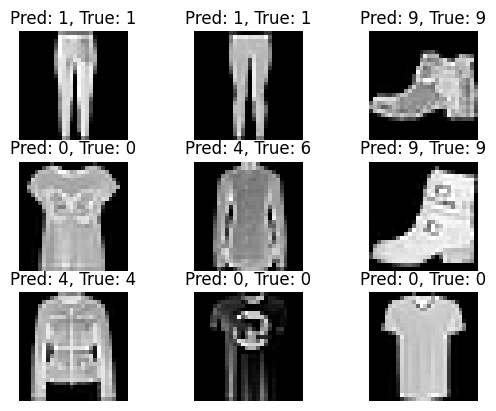

In [ ]:
# Get predictions
model.eval()
images, labels = next(iter(test_loader))
predictions = model(images).argmax(dim=1)

# Plot 9 images
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Pred: {predictions[i]}, True: {labels[i]}")
    plt.axis('off')
plt.show()




---



**BONUS**: Play with hyperparameters of the models and test the accuracy.